<a href="https://colab.research.google.com/github/imaboylol/itmo-advanced-ml-and-dl/blob/main/classification-knn/KNN_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Применение метода KNN для решения задачи классификации

Набор данных получен в результате переписи населения 1994 года и содержит информацию о некотором количестве людей, проживающих в США. Задача состоит в том, чтобы предсказать, зарабатывает человек более $50к в год или нет. Список признаков:

*   <b>age</b>: возраст человека.
*   <b>workclass</b>: статус занятости.
*   <b>fnlwgt</b>: количество людей, которое, по мнению переписи, представляет запись.
*   <b>education</b>: высший уровень образования, достигнутый человеком.
*   <b>education-num</b>: высший уровень образования, достигнутый человеком в числовой форме.
*   <b>marital-status</b>: семейное положение человека.
*   <b>occupation</b>: общий род занятий человека.
*   <b>relationship</b>: представляет то, чем этот человек является по отношению к другим (перекликается с признаком <b>marital-status</b>).
*   <b>race</b>: раса.
*   <b>sex</b>: пол.
*   <b>capital-gain</b>: прирост капитала.
*   <b>capital-loss</b>: убыток капитала.
*   <b>hours-per-week</b>: число рабочих часов в неделю.
*   <b>native-country</b>: страна происхождения.
*   <b>the label</b>: отклик -- зарабатывает больше $50к или меньше.



## Немного про метрики качества модели

Для начала рассмотрим так называемую матрицу ошибок (confusion matrix)
-- способ разделить объекты на $4$ группы в зависимости от комбинации
истинного класса и ответа классификатора:

-   TP (True Positives) -- верно классифицированные объекты, исходно     относящиеся к классу "$+1$";

-   TN (True Negatives) -- верно классифицированные объекты, исходно     относящиеся к классу "$-1$";

-   FN (False Negatives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$+1$" (ошибка I рода);

-   FP (False Positives) -- неверно классифицированные объекты, исходно     относящиеся к классу "$-1$" (ошибка II рода).

Обычно, конечно, оперируют не абсолютными показателями, а относительными
-- долями (rates), находящимися в диапазоне от $0$ до $1$:

-   доля правильных ответов классификатора (иногда -- точность): $$\mathsf{Accuracy} = \frac{TP + TN}{TP + FP + FN + TN}.$$ Эта величина показывает отношение количества верно классифицированных объектов к общему количеству классифицируемых объектов и, грубо говоря, оценивает вероятность случайному объекту быть правильно классифицированным.

-   доля истинно положительных примеров -- True Positives Rate (TPR) или     Sensitivity (чувствительность) или Recall: $$\mathsf{T P R}=\frac{T P}{T P+F N}.$$ Эта величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$+1$", к общему количеству объектов класса "$+1$". Иными словами -- это оценка вероятности, что объект, относящийся к классу "$+1$" будет классифицирован корректно.

-   доля ложно положительных примеров обозначается как -- False Positives Rate (FPR): $$\mathsf{F P R}=\frac{F P}{FP + TN}.$$ Величина показывает отношение количества неверно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован неверно.

-   Специфичность (Specificity) или True Negatives Rate (TNR): $$\mathsf{TNR} = 1 - \mathsf{F P R} =\frac{T N}{T N+F P}.$$ Величина показывает отношение количества верно классифицированных объектов, относящихся к классу "$-1$", к общему количеству объектов класса "$-1$", или оценивает вероятность, что объект, относящийся к классу "$-1$", будет классифицирован верно.

-   Precision (точность): $$\mathsf{Precision} =\frac{TP}{TP + FP}.$$ Величина показывает, какая доля объектов, отнесенных классификатором к классу "$+1$", действительно относится к этому классу.

Естественно возникает вопрос, нет ли какого-то обобщающего критерия,
который может характеризовать качество построенной модели. Один из них --
так называемая $F$-мера ($F_1$-мера, $F$ score, $F_1$ score)
определяется следующим соотношением:
$$F = F_1 = 2 \cdot \frac{\mathsf{Precision} \cdot \mathsf{Recall}}{\mathsf{Precision} + \mathsf{Recall}}.$$

**Замечание**. *$F$-мера является средним гармоническим величин
$\mathsf{Precision}$ и $\mathsf{Recall}$ и заключена в диапазоне
$[0, 1]$. Среднее гармоническое обладает важным свойством: оно близко к
нулю, если хотя бы один из аргументов близок к нулю. Поэтому оно является
куда более предпочтительным, чем, скажем, среднее арифметическое: если
алгоритм относит все объекты к положительному классу, то
$\mathsf{Recall}= 1$, а $\mathsf{Precision}$, скорее всего, будет
небольшим. Но тогда среднее арифметическое будет больше, чем $0.5$, что,
конечно, никуда не годится.*

## Импорт библиотек и чтение набора данных

In [103]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import seaborn as sns
from matplotlib import pyplot as plt

Считайте набор данных в датафрейм. Исходя из описания признаков можно сразу избавиться от признаков <code>education</code> и <code>marital-status</code>. Удалите соответствующие колонки из набора данных.

In [104]:
# < ENTER YOUR CODE HERE >
df = pd.read_csv('adult_data_train.csv', header=None, delimiter=';')
df = df.rename(columns={0: "features"})
df = df['features'].str.split(',',expand=True)
df = df.rename(columns={0: "age", 1: "workclass", 2: "fnlwgt", 3: "education", 4: "education-num",
                        5: "marital-status", 6: "occupation", 7: "relationship", 8: "race",
                        9: "sex", 10: "capital-gain", 11: "capital-loss", 12: "hours-per-week",
                        13: "native-country", 14: "label"})
df = df.drop([0], inplace=False)
#df_to_split.iloc[:, 1:] = df_to_split.iloc[:, 1:].astype(float)
df = df.drop(["education", "marital-status"], axis='columns')
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
1,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
2,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
3,20,?,122244,9,?,Not-in-family,White,Female,0,0,28,United-States,0
4,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
5,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26045,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26046,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26047,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


Определите количество числовых и нечисловых признаков.

Видим, что очевидно числовые фичи имеют тип данных object - let's do some feature engineering

In [105]:
df[['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week','label']] = df[['age',
'fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week','label']].astype(np.int64)

In [106]:
numeric_cols = df.select_dtypes(include='number').columns
object_cols = df.select_dtypes(include='object').columns
print("numerical features: ", numeric_cols, "\n")
print("object features: ", object_cols)

numerical features:  Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'label'],
      dtype='object') 

object features:  Index(['workclass', 'occupation', 'relationship', 'race', 'sex',
       'native-country'],
      dtype='object')


Постройте гистограмму распределения объектов по классам. Вычислите долю объектов класса $0$.

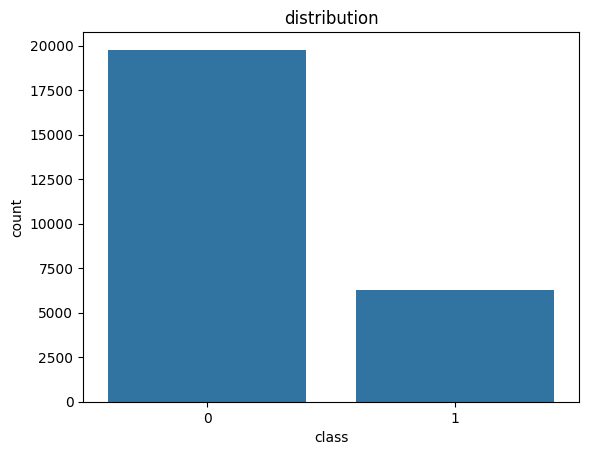

In [107]:
# < ENTER YOUR CODE HERE >
sns.countplot(data=df, x='label')
plt.title('distribution')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

In [108]:
class_counts = df['label'].value_counts()
print(class_counts)

label
0    19775
1     6273
Name: count, dtype: int64


# 1. Построение базовой модели

В качестве первого приближения имеет смысл построить модель классификации, опираясь исключительно на числовые признаки.

Отберите из набора данных только числовые признаки. При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки <b>с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>label</code>.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных.

Обучите модель <code>KNeighborsClassifier()</code> с параметрами по умолчанию на тренировочных данных.

Как видно из предыдущего пункта, в наборе данных наблюдается явный дисбаланс представителей классов. Это следует учесть при оценке модели. Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.

В качестве альтернативы можно использовать так называемый <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html"><code>classification_report()</code></a>, где приведены сразу несколько метрик (не стоит забывать про параметр <code>digits</code>).

In [109]:
# < ENTER YOUR CODE HERE >
df_numerical_only = df[['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week','label']]
X = df_numerical_only.drop(columns=['label'])
y = df_numerical_only['label']

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=df_numerical_only['label'])

mean_train_fnlwgt = X_train['fnlwgt'].mean()
print("mean fnlwgt value: ", mean_train_fnlwgt)

mean fnlwgt value:  190021.84393895767


In [110]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Вывод отчета о классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3955
           1       0.57      0.29      0.39      1255

    accuracy                           0.78      5210
   macro avg       0.69      0.61      0.63      5210
weighted avg       0.75      0.78      0.75      5210



In [111]:
f1 = f1_score(y_test, y_pred)
print("F1-score: ", f1)

F1-score:  0.38760504201680673


Стоит помнить, что KNN является метрическим классификатором, поэтому значения признаков перед обучением модели следует нормировать.

Обучите преобразование <code>MinMaxScaler()</code> на тренировочном наборе данных и примените его для тренировочных и тестовых данных.

Вычислите выборочное среднее колонки <code>fnlwgt</code> тренировочного набора данных после нормировки.

Заново обучите и оцените модель на преобразованных данных. Вычислите <code>f1_score()</code> модели.

In [112]:
# так мы получим тип данных pd.DataFrame для подсчёта среднего fnlwgt после нормализации
# т.к. pd.DataFrame -> MinMaxScaler() -> numpy.nd.array
X_train_minmax = (X_train - X_train.min()) / (X_train.max() - X_train.min())

In [113]:
mean_train_scaled_fnlwgt = X_train_minmax['fnlwgt'].mean()
print("mean train scaled fnlwgt: ", mean_train_scaled_fnlwgt)

mean train scaled fnlwgt:  0.12071069663476297


In [114]:
# < ENTER YOUR CODE HERE >
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [115]:
scaled_model = KNeighborsClassifier()
scaled_model.fit(X_train_scaled, y_train)

# Прогнозирование на тестовых данных
y_pred_scaled = scaled_model.predict(X_test_scaled)

# Вычисление нового F1-score
f1_scaled = f1_score(y_test, y_pred_scaled)
print("New F1 Score:", f1_scaled)

New F1 Score: 0.5180447693010507


Видно, что после линейной нормировки качество выросло.

<b>Важно: </b>На дальнейших этапах подразумевается использование линейной нормировки непосредственно перед обучением без дополнительных напоминаний.

# 2. Работа с нечисловыми признаками

## Визуализация

Для дальнейшего улучшения качества модели имеет смысл задействовать нечисловые признаки исходного датасета (без колонок <code>education</code> и <code>marital-status</code>).

Постройте гистограммы, иллюстрирующие частоту того или иного значения по каждому нечисловому признаку, например, при помощи <code>sns.barplot()</code>.

In [116]:
object_cols

Index(['workclass', 'occupation', 'relationship', 'race', 'sex',
       'native-country'],
      dtype='object')

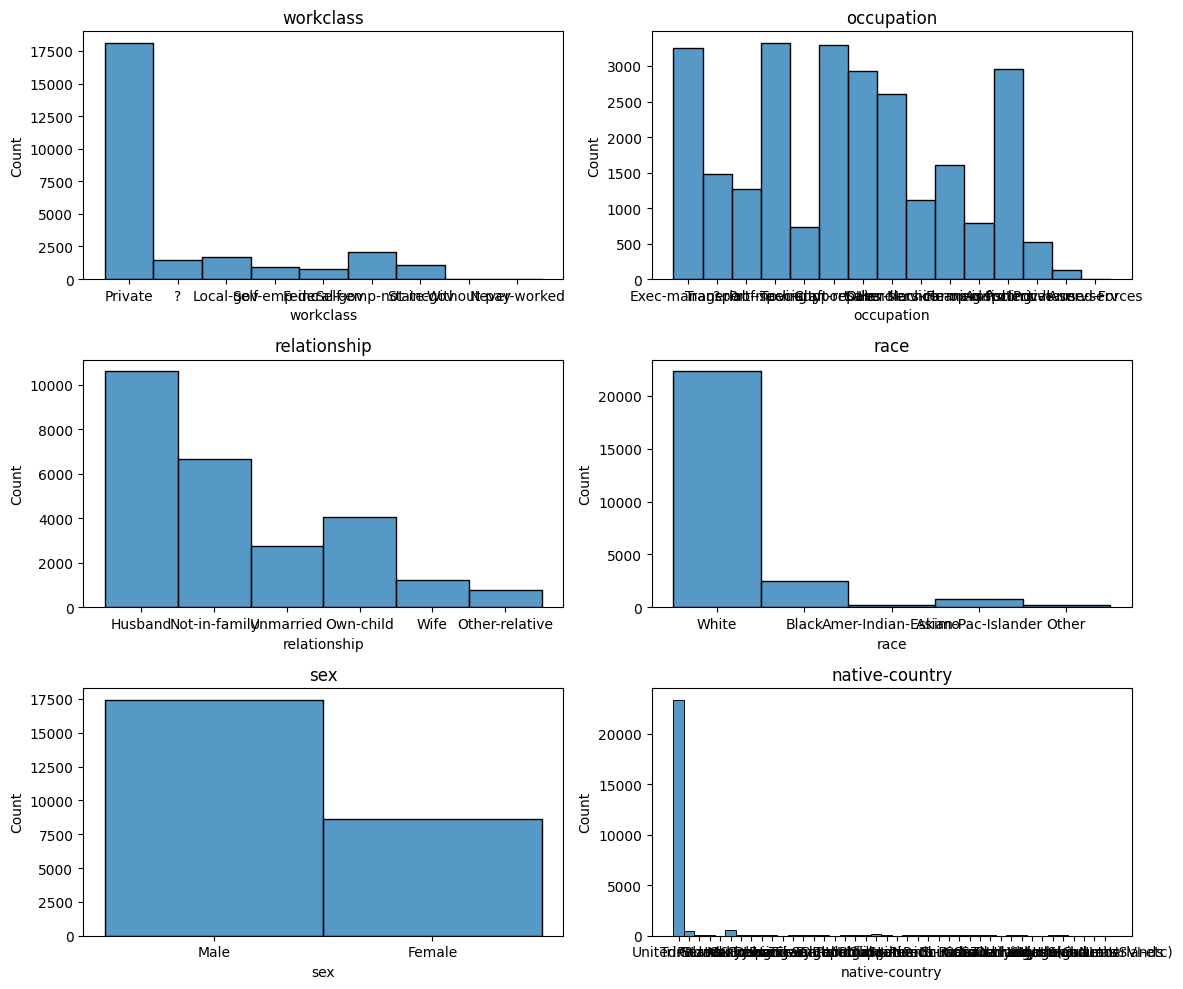

In [117]:
# < ENTER YOUR CODE HERE >
columns_to_plot = ['workclass', 'occupation', 'relationship', 'race', 'sex', 'native-country']

# Создание подграфиков
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Построение гистограмм
for col, ax in zip(columns_to_plot, axes.flatten()):
    sns.histplot(df[col], ax=ax, kde=False)
    ax.set_title(f'{col}')

plt.tight_layout()
plt.show()

## Удаление пропущенных значений

Определите число строк исходного набора данных (без колонок <code>education</code> и <code>marital-status</code>), в которых присутствует хотя бы одно пропущенное значение.

In [119]:
# сейчас бы знаки вопроса вместо NaN хранить
df = df.replace('?', np.nan, inplace=False)
df

,age,workclass,fnlwgt,education-num,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
1,32,Private,37210,13,Exec-managerial,Husband,White,Male,0,0,45,United-States,1
2,43,Private,101950,14,Exec-managerial,Not-in-family,White,Female,0,0,45,United-States,0
3,20,NaN,122244,9,NaN,Not-in-family,White,Female,0,0,28,United-States,0
4,40,Local-gov,24763,10,Transport-moving,Unmarried,White,Male,6849,0,40,United-States,0
5,24,Private,113936,13,Prof-specialty,Own-child,White,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,35,Self-emp-not-inc,179171,9,Sales,Unmarried,Black,Female,0,0,38,Germany,0
26045,39,Private,421633,10,Protective-serv,Unmarried,Black,Female,0,0,30,United-States,0
26046,55,Private,82098,9,Exec-managerial,Husband,Asian-Pac-Islander,Male,0,0,55,United-States,0
26047,26,Private,50053,13,Exec-managerial,Husband,White,Male,0,0,55,United-States,0


In [121]:
missing_count = df.isnull().any(axis=1).sum()
print("Число строк с хотя бы одним пропущенным значением:", missing_count)

Число строк с хотя бы одним пропущенным значением: 1914


Видно, что в датасете содержится менее 10% строк, содержащих пропуски. Выкидывать такое количество строк — не очень хорошее дело, но почему бы не попробовать обойтись без них.

Удалите строки, содеражащие пропуски. Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>.

Введите число полученных признаков.

In [123]:
df = df.dropna(inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24134 entries, 1 to 26048
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             24134 non-null  int64 
 1   workclass       24134 non-null  object
 2   fnlwgt          24134 non-null  int64 
 3   education-num   24134 non-null  int64 
 4   occupation      24134 non-null  object
 5   relationship    24134 non-null  object
 6   race            24134 non-null  object
 7   sex             24134 non-null  object
 8   capital-gain    24134 non-null  int64 
 9   capital-loss    24134 non-null  int64 
 10  hours-per-week  24134 non-null  int64 
 11  native-country  24134 non-null  object
 12  label           24134 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 2.6+ MB


In [124]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [125]:
df_encoded

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,label,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
1,32,37210,13,0,0,45,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2,43,101950,14,0,0,45,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
4,40,24763,10,6849,0,40,0,True,False,False,...,False,False,False,False,False,False,False,True,False,False
5,24,113936,13,0,0,40,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
6,51,237630,9,7298,0,50,1,False,True,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26044,35,179171,9,0,0,38,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
26045,39,421633,10,0,0,30,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
26046,55,82098,9,0,0,55,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False
26047,26,50053,13,0,0,55,0,False,True,False,...,False,False,False,False,False,False,False,True,False,False


Обучите модель классификации аналогично тому, как это было проделано для базовой модели. Вычислите <code>f1_score()</code> модели.



In [127]:
X = df_encoded.drop(columns=['label'])
y = df_encoded['label']

# splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=df_encoded['label'])

In [129]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [130]:
encoded_scaled_model = KNeighborsClassifier()
encoded_scaled_model.fit(X_train_scaled, y_train)

# Прогнозирование на тестовых данных
y_pred_scaled = encoded_scaled_model.predict(X_test_scaled)

# Вычисление нового F1-score
f1_encoded_scaled = f1_score(y_test, y_pred_scaled)
print("F1 Score (encoded & scaled):", f1_encoded_scaled)

F1 Score (encoded & scaled): 0.6097018246550957


Точность модели увеличилась по сравнению с моделью, которая использовала только числовые признаки.

## Заполнение пропущенных значений

Возможно точность еще повысится, если задействовать строки с пропущенными значениями. Используя исходный датасет (без колонок <code>education</code> и <code>marital-status</code>), заполните пропуски самым часто встречающимся значением в рамках столбца.

In [137]:
df = pd.read_csv('adult_data_train.csv', header=None, delimiter=';')
df = df.rename(columns={0: "features"})
df = df['features'].str.split(',',expand=True)
df = df.rename(columns={0: "age", 1: "workclass", 2: "fnlwgt", 3: "education", 4: "education-num",
                        5: "marital-status", 6: "occupation", 7: "relationship", 8: "race",
                        9: "sex", 10: "capital-gain", 11: "capital-loss", 12: "hours-per-week",
                        13: "native-country", 14: "label"})
df = df.drop([0], inplace=False)
#df_to_split.iloc[:, 1:] = df_to_split.iloc[:, 1:].astype(float)
df = df.drop(["education", "marital-status"], axis='columns')
df[['age','fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week','label']] = df[['age',
'fnlwgt','education-num','capital-gain', 'capital-loss', 'hours-per-week','label']].astype(np.int64)
df = df.replace('?', np.nan, inplace=False)

# fillna mode/median instead of missing values
df = df.apply(lambda x: x.fillna(x.mode()[0]) if x.dtype == "object" else x.fillna(x.mean()))
#check missings
#missing_count = df.isnull().any(axis=1).sum()
#print("Число строк с хотя бы одним пропущенным значением:", missing_count)

Число строк с хотя бы одним пропущенным значением: 0


In [138]:
#OHE
df = pd.get_dummies(df, drop_first=True)

In [140]:
#splitting
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27, stratify=df['label'])

In [141]:
#scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [142]:
custom_model = KNeighborsClassifier()
custom_model.fit(X_train_scaled, y_train)

# Прогнозирование на тестовых данных
y_pred_scaled = custom_model.predict(X_test_scaled)

# Вычисление нового F1-score
f1 = f1_score(y_test, y_pred_scaled)
print("F1 Score (for customed model):", f1)

F1 Score (for customed model): 0.5987261146496815


## Проклятие размерности

В последнем пункте был получен набор данных, содержащий 76 признаков (кстати, попробуйте объяснить, почему в случае удаления строк число признаков в итоге оказалось равным 75), что является достаточным для того, чтобы столкнуться с так называемым проклятием размерности.

Для того, чтобы классификатор давал более качественные результаты, имеет смысл более внимательно и вдумчиво поработать с признаками с учетом проклятия размерности. Например, вернуть в рассмотрение признаки <code>education-num</code> и <code>marital-status</code>. А также более глубоко вникнуть в саму природу признаков.